# Hiddenlayer可视化应用示例

由于`Pytorch`版本的更迭，导致在使用`Hiddenlayer`可视化工具时可能会出现报错，需要修改一些源码中的一些函数或变量名再进行使用

changed `_optimize_trace` to `_optimize_graph` in `pytorch_builder.py` line 71  
changed `return self.build_dot()._repr_svg_()` to `return self.build_dot()._repr_image_svg_xml()` in `graph.py` line 359

In [1]:
import torch
import torch.nn as nn
import hiddenlayer as hl
import numpy as np
import time
import warnings
warnings.filterwarnings('ignore')

## 1、使用Hiddenlayer实现网络结构的可视化

通过继承`nn.Module`基类构建一个网络模型，并命名为`ConvNet`

In [2]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Sequential(
             nn.Conv2d(1, 16, 3, 1, 1),
             nn.ReLU(),
             nn.AvgPool2d(2, 2)
         )
        self.conv2 = nn.Sequential(
             nn.Conv2d(16, 32, 3, 1, 1),
             nn.ReLU(),
             nn.MaxPool2d(2, 2)
         )
        self.fc = nn.Sequential(
             nn.Linear(32 * 7 * 7, 128),
             nn.ReLU(),
             nn.Linear(128, 64),
             nn.ReLU()
         )
        self.out = nn.Linear(64, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        output = self.out(x)
        return output

In [3]:
# 打印模型
MyConvNet = ConvNet()
print(MyConvNet)

ConvNet(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
  )
  (out): Linear(in_features=64, out_features=10, bias=True)
)


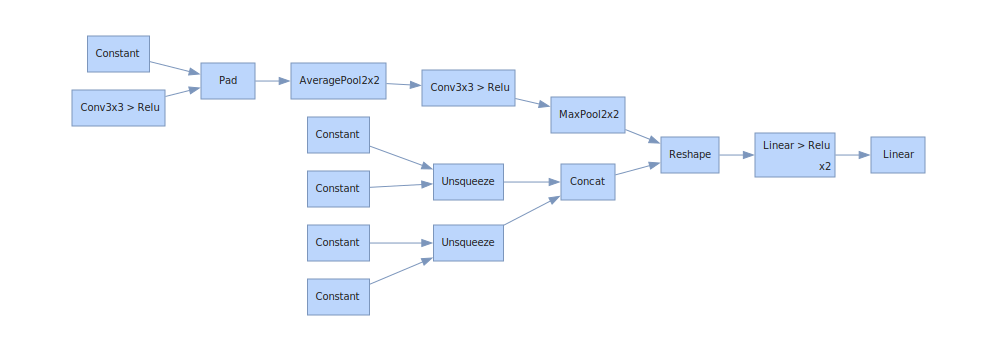

In [4]:
# 展示MyConvNet的神经网络计算图
vis_graph = hl.build_graph(MyConvNet, torch.zeros([1 ,1, 28, 28]))   # 获取绘制图像的对象
vis_graph.theme = hl.graph.THEMES["blue"].copy()     # 指定主题颜色
vis_graph
# vis_graph.save("./1")   # 保存图像的路径

## 2、使用Hiddenlayer实现训练度量的可视化

### 2.1 基本应用

为实现训练过程的跟踪，需要使用Hiddenlayer的两个对象：`History`用于存储训练指标的度量，`Canvas`用于将训练度量进行绘制

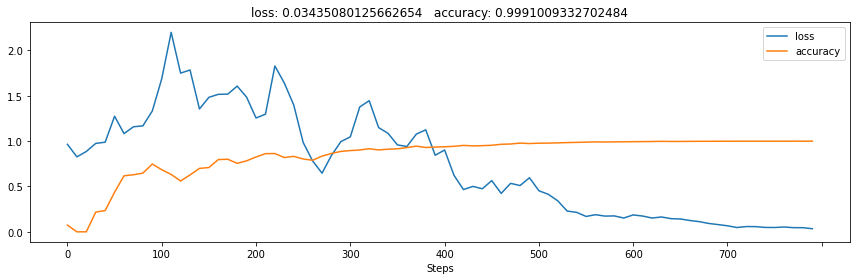

In [5]:
history1 = hl.History()
canvas1 = hl.Canvas()
# 用损失和准确率两个度量来模拟训练过程
loss = 1
accuracy = 0
for step in range(800):
    # 生成用于测试的伪数据
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))
    # 进行绘制
    if step % 10 == 0:
        # 将度量存储至history目标
        history1.log(step, loss=loss, accuracy=accuracy)
        # 在一个图中将两个度量进行绘制
        canvas1.draw_plot([history1["loss"], history1["accuracy"]])
        # 推迟0.1秒执行循环
        time.sleep(0.1)

### 2.2 实验比较

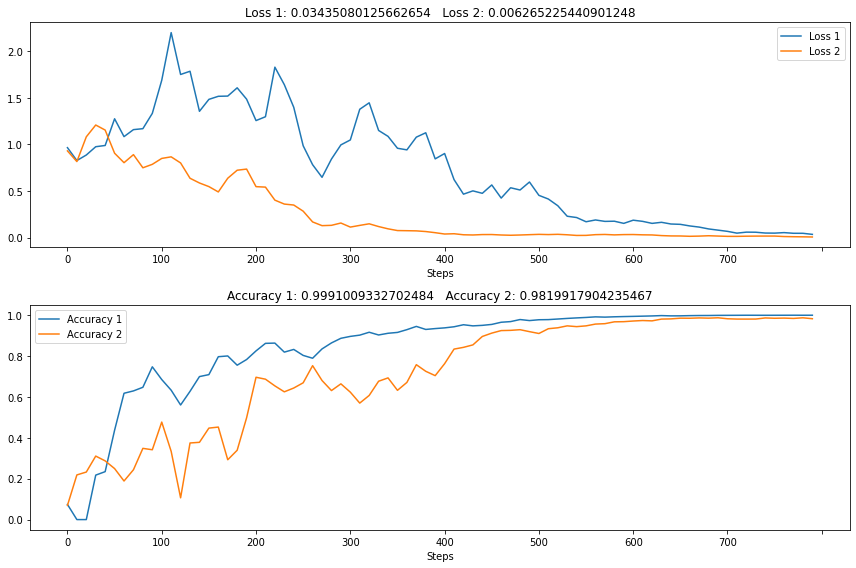

In [6]:
# 新建一个history和canvas的目标
history2 = hl.History()
canvas2 = hl.Canvas()
# 用损失和准确率两个度量来模拟训练过程
loss = 1
accuracy = 0
for step in range(800):
    # 生成用于测试的伪数据
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))
    # 进行绘制
    if step % 10 == 0:
        history2.log(step, loss=loss, accuracy=accuracy)
        # 绘制两张图
        # 利用with语句使得两张图同时绘制
        with canvas2:
            canvas2.draw_plot([history1["loss"], history2["loss"]],
                              labels=["Loss 1", "Loss 2"])
            canvas2.draw_plot([history1["accuracy"], history2["accuracy"]],
                              labels=["Accuracy 1", "Accuracy 2"])
        time.sleep(0.1)

### 2.3 History对象的保存及导入

In [7]:
# 保存两次实验的训练数据
history1.save("experiment1.pkl")
history2.save("experiment2.pkl")

In [8]:
# 导入数据至新的History对象
h1 = hl.History()
h2 = hl.History()
h1.load("experiment1.pkl")
h2.load("experiment2.pkl")

In [9]:
# 验证一下
h1.summary()

Last Step: 790
Training Time: 0:00:28.482421


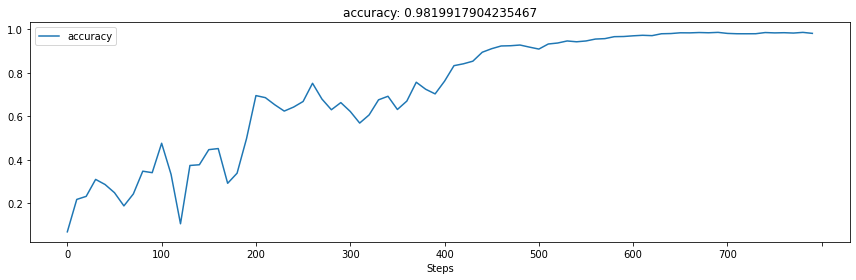

In [10]:
# 将第二次实验的数据绘制
hl.Canvas().draw_plot(h2["accuracy"])